## 正則化

### ライブラリ

In [13]:
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from torch.nn import functional as F
import torchvision
from torchvision import transforms
import utils

### L2正則

#### スクラッチ実装

In [ ]:
def get_convmodel():
    return nn.Sequential(
    # 3x28x28 -> 4x14x14
    nn.Conv2d(3, 4, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 4x14x14 -> 8x7x7
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 8x7x7 -> 16x4x4
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 16x4x4 -> 32x2x2
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    #nn.AdaptiveAvgPool2d(1),   # <- GAP
    # 32
    nn.Flatten(),
    # 10
    nn.Linear(128, 10)
)

In [9]:
# L2ノルムを計算
conv_model = get_convmodel()
l2_reg = torch.tensor(0.)
for name, param in conv_model.named_parameters():
    if 'weight' in name:
        l2_reg += torch.linalg.norm(param)**2   # フロベニアスノルム
# 正則化項を加えた損失
#loss += (weight_decay / (2*m)) * l2_reg

#### Pytorchで実装

In [10]:
optim.SGD(conv_model.parameters(), lr=0.03, weight_decay=0.01)

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.03
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0.01
)

#### L2正則有無でモデルを比較

In [11]:
conv_model = get_convmodel()
conv_model_l2 = get_convmodel()
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.40222, 0.4465], std=[0.2023, 0.1994, 0.2010])
])
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# optimizer(l2有/無)
opt = optim.SGD(conv_model.parameters(), lr=0.03)
opt_l2 = optim.SGD(conv_model_l2.parameters(), lr=0.03, weight_decay=0.001)

# 学習
num_epochs = 10
train_losses, val_losees, val_accuracies = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, num_epoch=num_epochs)
train_losses_l2, val_losees_l2, val_accuracies_l2 = utils.learn(conv_model_l2, train_loader, val_loader, opt_l2, F.cross_entropy, num_epoch=num_epochs)

Files already downloaded and verified
Files already downloaded and verified


epoch: 0: train error: 2.300292736429083, validation error: 2.286464156983774, validation accuracy: 0.15921677215189872


epoch: 1: train error: 2.145026148432661, validation error: 1.983369840851313, validation accuracy: 0.2815466772151899


epoch: 2: train error: 1.9155866813171856, validation error: 1.8682962444764148, validation accuracy: 0.32436708860759494


epoch: 3: train error: 1.7651368830819874, validation error: 1.6683790110334564, validation accuracy: 0.39655854430379744


epoch: 4: train error: 1.6605188883174107, validation error: 1.6113240205788915, validation accuracy: 0.42701740506329117


epoch: 5: train error: 1.5874888098148434, validation error: 1.573138734962367, validation accuracy: 0.439873417721519


epoch: 6: train error: 1.534894712440803, validation error: 1.4894156953956508, validation accuracy: 0.465684335443038


epoch: 7: train error: 1.4961779593201854, validation error: 1.4903426396695874, validation accuracy: 0.46924446202531644


epoch: 8: train error: 1.4651020628107174, validation error: 1.45474112033844, validation accuracy: 0.4819026898734177


epoch: 9: train error: 1.43726836720391, validation error: 1.4379309264919427, validation accuracy: 0.4811115506329114


epoch: 0: train error: 2.239624675277554, validation error: 2.1082609771173213, validation accuracy: 0.2566257911392405


epoch: 1: train error: 1.9774442734315878, validation error: 1.8698312693004366, validation accuracy: 0.3287183544303797


epoch: 2: train error: 1.8125422723457942, validation error: 1.742780587341212, validation accuracy: 0.3758900316455696


epoch: 3: train error: 1.689707451159387, validation error: 1.6318471114846724, validation accuracy: 0.4153481012658228


epoch: 4: train error: 1.6175807156526218, validation error: 1.5755059206033055, validation accuracy: 0.4387856012658228


epoch: 5: train error: 1.5592118190682454, validation error: 1.5604573684402658, validation accuracy: 0.43947784810126583


epoch: 6: train error: 1.5108218110735765, validation error: 1.4937000893339325, validation accuracy: 0.4624208860759494


epoch: 7: train error: 1.4772335193346224, validation error: 1.5181282487096666, validation accuracy: 0.46014636075949367


epoch: 8: train error: 1.4522388527155532, validation error: 1.4261590317834782, validation accuracy: 0.49050632911392406


epoch: 9: train error: 1.4259710278352509, validation error: 1.4295280719105201, validation accuracy: 0.48239715189873417


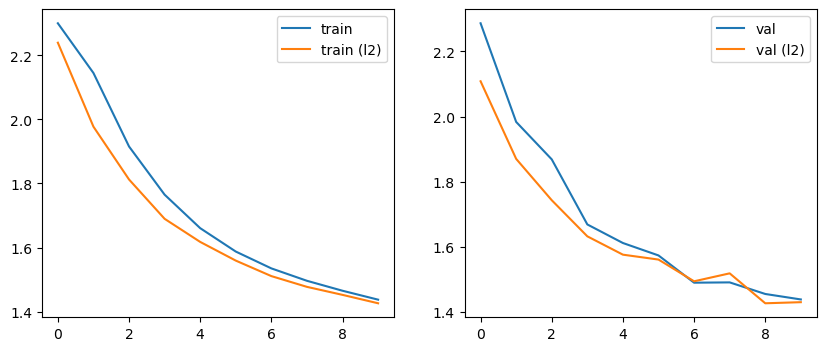

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(train_losses, label='train')
ax[0].plot(train_losses_l2, label='train (l2)')
ax[1].plot(val_losees, label='val')
ax[1].plot(val_losees_l2, label='val (l2)')
ax[0].legend()
ax[1].legend()

### ドロップアウト

#### スクラッチ実装

In [20]:
def dropout(X, drop_p):
    keep_p = 1 - drop_p
    mask = torch.rand(X.shape) < keep_p
    return X * mask / keep_p

### PyTorchで実装

In [21]:
model = nn.Sequential(
    nn.Linear(64, 20),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(20, 10)
)